In [1]:
#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
from scipy.spatial.distance import cdist
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib as mat
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
import figurefirst

#misc
import time
np.set_printoptions(suppress=True)


In [2]:
# set_number = 5
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
# df = pd.read_hdf(dir+'Run01Run02Run03_ExpectedPP.h5') # filtered-4hz-2meterPointsRemoved-WithVectorComponents
df = pd.read_hdf(dir+'ContinuousNotWindy4Hz.h5')
# dir1 = '~/Documents/Myfiles/DataAnalysis/data/Sprints/LowRes/'
# df2=pd.read_hdf(dir1+'NotWindyStatsPP.h5')

In [3]:
def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

In [4]:
# ## getting the indexes for odor over a threshold to determine each encounter
def get_index(df):
    idx = []
    for i in range(len(df.filtered_odor)):
        if (df.filtered_odor[i]>4):
            idx.append(df.index[i])

    from itertools import groupby
    from operator import itemgetter
    index = [ ]
    for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
        index.append((list((map(itemgetter(1), g)))))
    return index

In [5]:
fdf=pd.DataFrame()
index = get_index(df)
        
i = 0
#to compare with R^2 analysis
avg_dist_from_source = []
while i<len(index):
    avg_dist_from_source.append(np.mean(df.distance_along_streakline[index[i]]))
    i+=1
fdf['avg_dist_along_streakline']=avg_dist_from_source


i=0
avg_dist_source = []
while i<len(index):
    avg_dist_source.append(np.mean(df.distance_from_source[index[i]]))
    i+=1
fdf['avg_dist_from_source']=avg_dist_source

avg_dist_from_streakline = []
i = 0
while i<len(index):
    avg_dist_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
    i+=1
fdf['avg_dist_from_streakline']=avg_dist_from_streakline

# RELATIVE MOTION

rel_parallel_enc = []
i= 0
while i<len(index):
    rel_parallel_enc.append(np.mean(df.relative_parallel_comp[index[i]]))
    i+=1
fdf['avg_parallel_encounter']=rel_parallel_enc


rel_perpendicular_enc = []
i= 0
while i<len(index):
    rel_perpendicular_enc.append(np.mean(df.relative_perpendicular_comp[index[i]]))
    i+=1
fdf['avg_perpendicular_encounter']=rel_perpendicular_enc


rel_parallel_inter = []
i= 0
while i < len(index):
    if i < (len(index)-1):
        rel_parallel_inter.append(np.mean(df.relative_parallel_comp[index[i][-1]:index[i+1][0]]))
        i+=1
    else:
        rel_parallel_inter.append(0)
        i+=1

fdf['avg_parallel_intermittency']=rel_parallel_inter

       
rel_perpendicular_inter = []
i= 0
while i < len(index):
    if i < (len(index)-1):
        rel_perpendicular_inter.append(np.mean(df.relative_perpendicular_comp[index[i][-1]:index[i+1][0]]))
        i+=1
    else:
        rel_perpendicular_inter.append(0)
        i+=1
        
fdf['avg_perpendicular_intermittency']=rel_perpendicular_inter

print('done')

done


In [6]:
# time of the encounters
i = 0
length_of_encounter = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i < len(index):
    length_of_encounter.append(dt*(len(index[i])))
    i+=1
fdf['length_of_encounter'] = length_of_encounter

#time between the encounters
i = 0
intermittency = []
while i < len(index):
    if i < (len(index)-1):
        intermittency.append((index[i+1][0] - index[i][-1])*dt)
        i+=1
    else:
        intermittency.append(0)
        i+=1
fdf['odor_intermittency'] = intermittency

## Trajectory speed during Intermittency
i = 0
speed_at_intermittency=[]
while i < len(index):
    if i < (len(index)-1):
        x = np.mean(df.gps_linear_x[index[i][-1]:index[i+1][0]])
        y = np.mean(df.gps_linear_y[index[i][-1]:index[i+1][0]])
        z = np.mean(df.gps_linear_z[index[i][-1]:index[i+1][0]])
        speed_at_intermittency.append(np.sqrt(x**2+y**2+z**2))
        i+=1
    else:
        speed_at_intermittency.append(0)
        i+=1

fdf['speed_at_intermittency'] = speed_at_intermittency

## Trajectory speed during Encounters
i = 0
speed_at_encounter=[]
while i < len(index):
        x = np.mean(df.gps_linear_x[index[i]])
        y = np.mean(df.gps_linear_y[index[i]])
        z = np.mean(df.gps_linear_z[index[i]])
        speed_at_encounter.append(np.sqrt(x**2+y**2+z**2))
        i+=1
fdf['speed_at_encounter'] = speed_at_encounter

print('done')

done


In [7]:
# # encounter_frequency_window_model
# ## encounter frequency
# start = []
# for i in range (len(index)):
#     start.append(index[i][0])
# df['efreq'] = np.zeros(len(df))
# df.efreq.iloc[start] = 1

# # 0th index
# filtered=[]
# t = []
# tau=2
# t.append(np.arange(0, df.time[start[0]]+dt, dt))
# kernel = np.exp(-t[0]/tau)

# w = df.efreq[:start[0]+1]
# filtered.append(signal.convolve(kernel, w, mode = 'same'))

# for i in range(1, len(start)):
#     t.append(np.arange(df.time[start[i-1]], df.time[start[i]]+dt, dt))
#     kernel = np.exp(-t[i]/tau) # current encounter time - last encounter time
#     w = df.efreq[:start[i]+1]  # encounter vector until current encounter
#     filtered.append(signal.convolve(kernel, w, mode = 'same'))

In [72]:
# sig = np.repeat([0., 1., 0., 1.,0.,1.,0.], 100)
## encounter frequency
sig = df.efreq
def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

t = df.time[0:100]
tau = 2
kernel = exp_ker(t,tau)
filtered = signal.convolve(sig, kernel, mode='same') / sum(win)

<ipython-input-73-e5153f596304>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


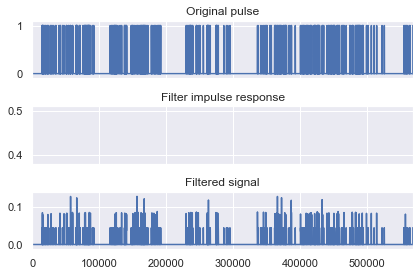

In [73]:
import matplotlib.pyplot as plt
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_win.plot(kernel)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()

In [74]:
# binary vector
start = []
for i in range (len(index)):
    start.append(index[i][0])
df['efreq'] = np.zeros(len(df))
df.efreq.iloc[start] = 1

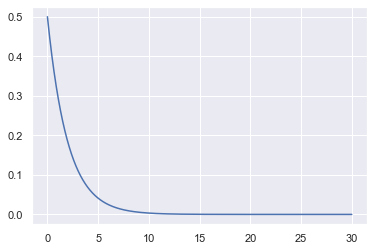

In [94]:
plt.plot(t, kernel)

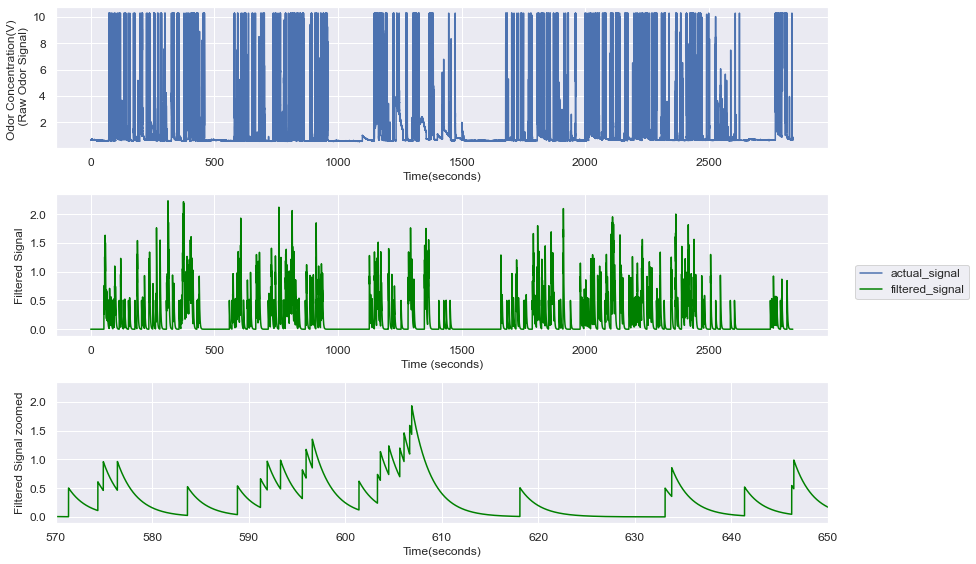

In [115]:
## encounter frequency
def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

t = df.time[:8008]
tau = 2
kernel = exp_ker(t,tau)

filtered = signal.convolve(df.efreq, kernel, mode='same', method='auto')
f, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,8))

ax1.plot(df.time, df.odor, label='actual_signal')
ax1.set_ylabel('Odor Concentration(V) \n (Raw Odor Signal)')
ax1.set_xlabel('Time(seconds)')

c1='green'
ax2.plot(df.time,filtered, c =c1, label='filtered_signal')
ax2.set_ylabel('Filtered Signal')
ax2.set_xlabel('Time (seconds)')

ax3.plot(df.time, filtered, c=c1)
ax3.set_ylabel('Filtered Signal zoomed')
ax3.set_xlabel('Time(seconds)')
ax3.set_xlim(570,650)

f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f,12)
f.savefig('../../Figure/filtered.jpeg', bbox_inches='tight')

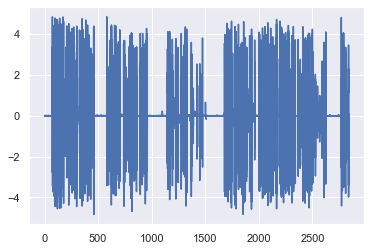

In [116]:
slope = pd.Series(np.gradient(df.odor), df.time, name='slope')
plt.plot(slope)

In [78]:
### Wind speed during encounter and Intermittency
i = 0
wind_speed_encounter = []
while i<len(index):
    wind_speed_encounter.append(np.mean(df.S2[index[i]]))
    i+=1
fdf['wind_speed_encounter'] = wind_speed_encounter

### Wind speed during intermittency
i = 0
wind_speed_intermittency = []
while i<len(index):
    if i < (len(index)-1):
        wind_speed_intermittency.append(np.mean(df.S2[index[i][-1]:index[i+1][0]]))
        i+=1
    else:
        wind_speed_intermittency.append(0)
        i+=1
fdf['wind_speed_intermittency'] = wind_speed_intermittency

In [83]:
fdf[:339]

,avg_dist_along_streakline,avg_dist_from_source,avg_dist_from_streakline,avg_parallel_encounter,avg_perpendicular_encounter,avg_parallel_intermittency,avg_perpendicular_intermittency,length_of_encounter,odor_intermittency,speed_at_intermittency,speed_at_encounter,wind_speed_encounter,wind_speed_intermittency
0,3.976977,18.715367,16.483016,0.196792,-0.170893,0.338863,-0.492337,0.709339,0.029972,1.260629,1.153945,1.115167,1.257912
1,4.637342,19.071123,16.326143,0.069178,-0.369076,-0.761114,-1.078110,0.319702,9.386255,0.446447,1.193161,1.368960,1.090318
2,8.968622,17.857422,13.689847,0.789751,-1.084748,0.866758,-0.467660,0.164846,0.014986,1.474871,1.417176,0.606199,0.642247
3,9.099218,17.639501,13.471659,0.987221,-0.247048,0.496622,-1.362169,0.229786,2.667515,1.113180,1.564449,0.641823,0.707897
4,11.004728,14.847891,11.039023,-0.646825,-1.843886,-0.650845,-1.822941,0.054949,0.009991,1.302055,1.311874,0.754991,0.752244
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,5.814941,6.081866,3.068605,2.183989,-0.684925,2.151050,-0.680535,0.264753,0.009991,1.292011,1.296130,1.006575,1.046913
1379,5.216593,5.791992,2.927923,1.893740,-0.542198,1.349554,-1.335280,0.209805,0.009991,1.063456,1.140992,1.029948,0.970572
1380,3.976459,5.613792,2.780030,1.282148,-1.332540,1.162664,-1.380280,0.109898,0.139870,1.125294,1.069498,0.889284,0.750765
1381,4.134381,5.354012,2.459818,1.185432,-1.429460,1.203270,-1.424760,0.064939,0.019981,1.314858,1.260541,0.703148,0.680710


In [84]:
fdf  = fdf.drop(fdf.index[0:339]) # 78 rows for 2Hz
                                 # 136 rows for 4Hz; 
                                 # 148 rows for 8hz ; 
                                 # 165 rows for 10Hz; 232 rows for 20hz; 291 rows for 40hz
                                 # 319 rows for 60Hz
                                 # 339 rows for 80Hz 
fdf.reset_index(inplace=True, drop=True) 

In [85]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
fdf.to_hdf(dir+'NotWindyContinuousStats80Hz.h5', key='fdf', mode='w')

In [97]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
fdf = pd.read_hdf(dir+'NotWindyContinuousStats4Hz.h5')

In [99]:
# f, (ax1,ax2) = plt.subplots(1,2, figsize=(14,6))
# ax1.scatter(fdf1.speed_at_intermittency, np.log10(fdf1.odor_intermittency), c =fdf1.avg_dist_from_source, label='Data-Group-01')
# # ax1.axhline(0, linestyle='dashed' , color = 'green')
# ax1.set_xlabel('Sensor Speed at Intermittency (m/s)')
# ax1.set_ylabel('log10(Length_Odor_Intermittency(secs))')
# # ax1.legend()

# ax2.scatter(fdf2.speed_at_intermittency, np.log10(fdf2.odor_intermittency), c =fdf2.avg_dist_from_source, label='Data-Group-02')
# # ax1.axhline(0, linestyle='dashed' , color = 'green')
# ax2.set_xlabel('Sensor Speed at Intermittency (m/s)')
# ax2.set_ylabel('log10(Length_Odor_Intermittency(secs))')
# # ax2.legend()

# f.tight_layout()
# figurefirst.mpl_functions.set_fontsize(f, 12)
# # f.savefig('../../Figure/dividedDataBlobs.jpeg')

In [100]:
# fdf['log_transform_int']= np.log10(fdf.odor_intermittency)
# query1 = 'log_transform_int>0'
# query2 = 'log_transform_int<=0'
# fdf1 = fdf.query(query1)
# fdf2 = fdf.query(query2)
# # fdf=fdf_new

In [101]:
fdf['log_LOE']=np.log10(fdf.length_of_encounter)

In [102]:
# f, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize =(14,12), 
#                             gridspec_kw={'height_ratios':[3,3],'width_ratios': [4,4]})

# min_val = -0.5
# max_val = 2
# lblpad = -60
# var = ax1.scatter((fdf.avg_perpendicular_encounter), np.log10(fdf.length_of_encounter),
#                   c=(fdf.avg_parallel_encounter), cmap='inferno', vmin=min_val, vmax=max_val)
# ax1.set_xlabel('Log10(Length of Encounter)')
# ax1.set_ylabel('Relative Perpendicular Component')

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.2)
# f.colorbar(var, cax=cax, orientation = 'vertical')
# cax.get_yaxis().labelpad = lblpad
# cax.set_ylabel('Relative Parallel Component', rotation=270)

# var1 = ax2.scatter((fdf.avg_perpendicular_intermittency), np.log10(fdf.odor_intermittency),
#                    c=(fdf.avg_parallel_intermittency),cmap='inferno',vmin=min_val, vmax=max_val)

# ax2.set_xlabel('Log10(Length of Intermittency)')
# ax2.set_ylabel('Relative Perpendicular Component')

# divider = make_axes_locatable(ax2)
# cax1 = divider.append_axes('right', size='5%', pad=0.2)
# f.colorbar(var1, cax=cax1, orientation = 'vertical')
# cax1.get_yaxis().labelpad = lblpad
# cax1.set_ylabel('Relative Parallel Component', rotation=270)

# var2 = ax3.scatter(np.abs(fdf.avg_parallel_intermittency),np.abs(fdf.avg_perpendicular_encounter), 
#                   c=np.log10(fdf.length_of_encounter), cmap='inferno', vmin=min_val, vmax=max_val)
# ax3.set_xlabel('Absolute(Relative Parallel Component)')
# ax3.set_ylabel('Absolute(Relative Parallel Component)')


# divider = make_axes_locatable(ax3)
# cax2 = divider.append_axes('right', size='5%', pad=0.2)
# f.colorbar(var, cax=cax2, orientation = 'vertical')
# cax2.get_yaxis().labelpad = lblpad
# cax2.set_ylabel('Log10(Length of Encounter)', rotation=270)

# var3 = ax4.scatter(np.abs(fdf.avg_parallel_intermittency),np.abs(fdf.avg_perpendicular_intermittency), 
#                    c=np.log10(fdf.odor_intermittency),cmap='inferno',vmin=min_val, vmax=max_val)
# ax4.set_xlabel('Absolute(Relative Parallel Component)')
# ax4.set_ylabel('Absolute(Relative Parallel Component)')

# divider = make_axes_locatable(ax4)
# cax3 = divider.append_axes('right', size='5%', pad=0.2)
# f.colorbar(var1, cax=cax3, orientation = 'vertical')
# cax3.get_yaxis().labelpad = lblpad
# cax3.set_ylabel('Log10(Length of Intermittency)', rotation=270)


# f.tight_layout()
# figurefirst.mpl_functions.set_fontsize(f, 12)
# # f.savefig('../../Figure/fdffiltered.jpeg')

In [103]:
## Normalization
# normalized_fdf=(fdf-fdf.mean())/fdf.std()

## mean max normalization
# normalized_fdf=(fdf-fdf.min())/(fdf.max()-fdf.min())
# fdf.to_hdf(dir+'WindyStats.h5', key='df', mode='w')

In [9]:
#temp

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
fdf = pd.read_hdf(dir+'NotWindyContinuousStats4Hz.h5')
fdf['log_LOE']=np.log10(fdf.length_of_encounter)

In [12]:
pd.set_option('use_inf_as_na', True)

In [13]:
encounters=smf.ols(formula='log_LOE ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
intermittencies=smf.ols(formula='np.log10(odor_intermittency) ~ np.abs(fdf.avg_perpendicular_intermittency) + np.abs(fdf.avg_parallel_intermittency)', data=fdf).fit()
print(intermittencies.summary())
fdf['encounter_resid'] = encounters.resid
fdf['intermittency_resid'] = intermittencies.resid
# print(encounters.summary())
# plt.rc('figure', figsize=(12, 6))
# plt.text(0.01, 0.05, str(intermittencies.summary()), {'fontsize': 12}, fontproperties = 'monospace')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('../../Figure/intermittencyreg.jpeg')

                                 OLS Regression Results                                 
Dep. Variable:     np.log10(odor_intermittency)   R-squared:                       0.041
Model:                                      OLS   Adj. R-squared:                  0.036
Method:                           Least Squares   F-statistic:                     8.400
Date:                          Thu, 30 Sep 2021   Prob (F-statistic):           0.000267
Time:                                  13:44:10   Log-Likelihood:                -498.85
No. Observations:                           401   AIC:                             1004.
Df Residuals:                               398   BIC:                             1016.
Df Model:                                     2                                         
Covariance Type:                      nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
distance=smf.ols(formula='(avg_dist_from_source) ~ encounter_resid + intermittency_resid', data=fdf).fit()
print(distance.summary())

                             OLS Regression Results                             
Dep. Variable:     avg_dist_from_source   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                  0.001
Method:                   Least Squares   F-statistic:                     1.183
Date:                  Thu, 30 Sep 2021   Prob (F-statistic):              0.308
Time:                          13:45:53   Log-Likelihood:                -1391.4
No. Observations:                   401   AIC:                             2789.
Df Residuals:                       398   BIC:                             2801.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

In [15]:
distencounter=smf.ols(formula='distance.resid ~ encounter_resid+intermittency_resid', data=fdf).fit()
print(distencounter.summary())
# plt.rc('figure', figsize=(12, 6))
# plt.text(0.01, 0.05, str(distencounter.summary()), {'fontsize': 15}, fontproperties = 'monospace') # approach improved by OP -> monospace!
# plt.axis('off')
# plt.tight_layout()

# plt.savefig('../../Figure/distencreg.jpeg')

                            OLS Regression Results                            
Dep. Variable:         distance.resid   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5930
Date:                Wed, 29 Sep 2021   Prob (F-statistic):              0.553
Time:                        12:09:53   Log-Likelihood:                -28.389
No. Observations:                 401   AIC:                             62.78
Df Residuals:                     398   BIC:                             74.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0008    

In [101]:
regresult=pd.DataFrame()
regresult['cutoff_frequency'] = np.array([2,4,8,10,20,40,60,80])
regresult['Rsquare'] = np.array([0.141,0.166,0.136,0.135,0.147,0.152,0.161,0.195])
regresult['speed']=np.array([0.3322,0.3757,0.3454,0.3450,0.3590,0.3638,0.3692, 0.4009])
regresult['encounter']=np.array([0.0218, 0.0051,-0.0043,-0.0026, -0.0256,-0.0342,-0.0351,-0.0271])
regresult['intermittency']=np.array([-0.0220, -0.0171,-0.0119,-0.0053,-0.0169,-0.0230,-0.0262,-0.0224])

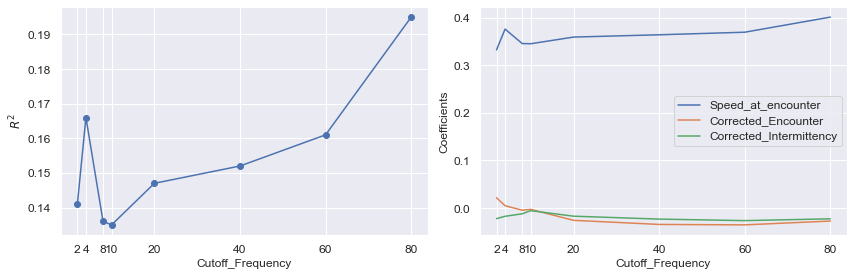

In [106]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(regresult.cutoff_frequency, regresult.Rsquare)
ax1.scatter(regresult.cutoff_frequency, regresult.Rsquare)
ax1.set_ylabel('$R^2$')
ax1.set_xlabel('Cutoff_Frequency')
ax1.set_xticks(regresult.cutoff_frequency)
# ax1.set_yticks(regresult.Rsquare)

ax2.plot(regresult.cutoff_frequency, regresult.speed, label='Speed_at_encounter')
ax2.plot(regresult.cutoff_frequency, regresult.encounter, label ='Corrected_Encounter')
ax2.plot(regresult.cutoff_frequency, regresult.intermittency, label = 'Corrected_Intermittency')
ax2.set_xticks(regresult.cutoff_frequency)
ax2.legend()
ax2.set_ylabel('Coefficients')
ax2.set_xlabel('Cutoff_Frequency')
f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f,12)
plt.savefig('../../Figure/regressionsummary.jpeg')

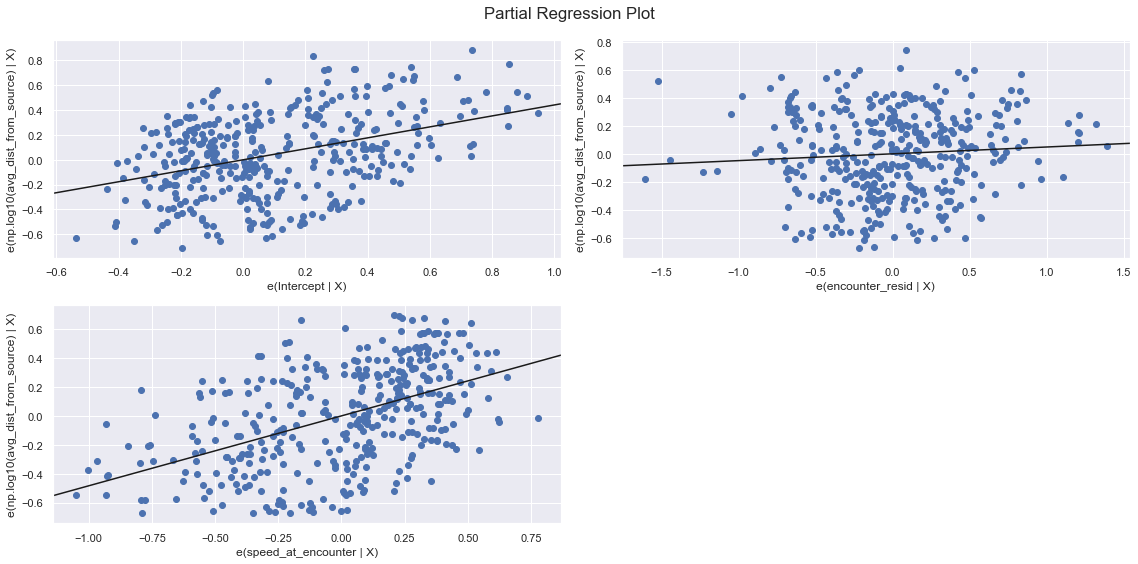

In [41]:
# plt.rc("figure", figsize=(16,8))
# plt.rc("font", size=14)
# fig = sm.graphics.plot_partregress_grid(distance)
# fig.tight_layout(pad=1.0)
# plt.savefig('../../Figure/partreg.jpeg')

#### Not Required Stats

In [ ]:

## Odor Standard Deviation
i = 0
st_dev = []
while i<len(index):
    st_dev.append(np.std(df.odor[index[i]]))
    i+=1
fdf['odor_stdev'] = st_dev

## Trisonica Mean Pressure
i = 0
pressure = []
while i<len(index):
    pressure.append(np.mean(df.trisonica_pressure[index[i]]))
    i+=1
fdf['tri_pressure'] = pressure

## Trisonica Mean Temperature
i = 0
temperature = []
while i<len(index):
    temperature.append(np.mean(df.trisonica_temperature[index[i]]))
    i+=1
fdf['tri_temperature'] = temperature

## Trisonica Mean Linear acceleration
i = 0
linear_acc_x = []
while i<len(index):
    linear_acc_x.append(np.mean(df.imu_linear_acc_x[index[i]]))
    i+=1
fdf['linear_acc_x'] = linear_acc_x

i = 0
linear_acc_y = []
while i<len(index):
    linear_acc_y.append(np.mean(df.imu_linear_acc_y[index[i]]))
    i+=1
fdf['linear_acc_y'] = linear_acc_y

i = 0
linear_acc_z = []
while i<len(index):
    linear_acc_z.append(np.mean(df.imu_linear_acc_z[index[i]]))
    i+=1
fdf['linear_acc_z'] = linear_acc_z

## Trisonica Mean Angular vel
i = 0
angular_vel_x = []
while i<len(index):
    angular_vel_x.append(np.mean(df.imu_angular_x[index[i]]))
    i+=1
fdf['imu_angular_x'] = angular_vel_x

i = 0
angular_vel_y = []
while i<len(index):
    angular_vel_y.append(np.mean(df.imu_angular_y[index[i]]))
    i+=1
fdf['imu_angular_y'] = angular_vel_y

i = 0
angular_vel_z = []
while i<len(index):
    angular_vel_z.append(np.mean(df.imu_angular_z[index[i]]))
    i+=1
fdf['imu_angular_z'] = angular_vel_z

In [ ]:
# fig, ax = plt.subplots(figsize=(12,6))
# ax = sns.distplot(np.log(df1['length_of_encounter']), label = 'High Resolution')
# ax=sns.distplot(np.log(df2['length_of_encounter']), label = 'Low Resolution')
# ax.set_xlim(-8, 8)
# ax.legend()
# # fig.savefig('../../Figure/distplot.jpeg')